# POC in a word perspective

Motivation:

* Manipulate words to make the documents more similar.   
* Ignore stop words
* Replace with Lemmas
* Replace words with similar words using embedding
* Log changes

## 0) Upload data

In [ ]:
# Imports
import sklearn
import pandas as pd
import numpy as np
import random
import re
from numpy.linalg import norm
from sklearn.model_selection import train_test_split
from itertools import islice
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Uploading the data
COLAB = True

Mounting Google drive to COLAB

In [ ]:
if COLAB:
    from google.colab import drive
    from os.path import exists

    amazon_train_file = 'train.ft.txt.bz2'

    if exists(amazon_train_file):
        train_file = amazon_train_file
    else:
        drive.mount('/content/drive/')

        # For Hadas' drive
        my_dir = 'drive/MyDrive/Y-data/Intuit-K-anonimity/'

        # For Lior's drive
        #my_dir = 'drive/MyDrive/Y-data/Y-DATA_PROJECT/'

        train_file = my_dir + '/train.ft.txt.bz2'
else:
    train_file = '../data/' + 'train.ft.txt.bz2'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Uploading the Amazon review database

In [ ]:
# Credit https://www.kaggle.com/code/anshulrai/cudnnlstm-implementation-93-7-accuracy
import bz2

def reading_bz_file(train_file):

    # Readling the file to list of comments
    train_file = bz2.BZ2File(train_file)
    train_file_lines = train_file.readlines()

    # Converting from raw binary strings to strings that can be parsed
    train_file_lines = [x.decode('utf-8') for x in train_file_lines]

    # Extracting the labels and sentences
    train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file_lines]
    train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file_lines] # And converting to lower case

    # Converting to df
    df = pd.DataFrame(list(zip(train_sentences, train_labels)), columns =['txt', 'sentiment'])

    # Adding number of words
    df['num_of_words'] = df['txt'].apply(lambda x : len(x.split(' ')))

    return df

In [ ]:
df = reading_bz_file(train_file)

Creating dataframe

In [ ]:
# create a data frame from train data:
df.head()

,txt,sentiment,num_of_words
0,stuning even for the non-gamer: this sound tra...,1,80
1,the best soundtrack ever to anything.: i'm rea...,1,97
2,amazing!: this soundtrack is my favorite music...,1,129
3,excellent soundtrack: i truly like this soundt...,1,118
4,"remember, pull your jaw off the floor after he...",1,87


Filtering only short sentences

In [ ]:
max_len = 20
df_short_sentences = df[df['num_of_words'] <= max_len] # Filtering using pandas is much faster
print(df_short_sentences.shape)

(43870, 3)


In [ ]:
# Free RAM
del(df)

## 1 )Selecting only the most similar documents
To further filter the num of sentences we work on, and make our life easier for POC, we will use the Jaccard index and choose the sentences with highest score

Defining a function to calculate Jaccard index between two sentences

In [ ]:
def jaccard_index(sentence1, sentence2):
    """ Calc Jaccard index for each pair of sentences """
    words1 = set(sentence1.split())
    words2 = set(sentence2.split())
    intersection = len(words1.intersection(words2))
    union = len(words1.union(words2))
    jaccard = intersection / union
    return jaccard

Testing

In [ ]:
jaccard_index('I love white choclate', 'I love love brown choclate')

0.6

Filtering

In [ ]:
indices_list = list(df_short_sentences.index)
indices_list_short = indices_list[1:1000] # take only 1000 

In [ ]:
len(indices_list)

43870

In [ ]:
%%time
# Create a list of sentence texts
sentences = list(df_short_sentences.txt.loc[indices_list_short])

# Compute the Jaccard index for all pairs of sentences
jaccard_index_dict = {(indices_list_short[i],indices_list_short[j]): jaccard_index(sentences[i], sentences[j]) for i in range(len(sentences)) for j in range(i+1, len(sentences))}

# Sort the dictionary by its values in descending order
sorted_dict = dict(sorted(jaccard_index_dict.items(), key=lambda item: item[1], reverse=True))

CPU times: user 4.23 s, sys: 75 ms, total: 4.3 s
Wall time: 4.35 s


Print the two sentences with highest JAccard ~0.8

In [ ]:
print(df_short_sentences.loc[23472,"txt"])
print(df_short_sentences.loc[23473,"txt"])

poor quality: the seat covers started coming loose at the seams immediately upon putting them on the seats.
poor quality.: the seat covers started coming loose at the seams immediately upon putting them on the seats.


Filter the df to get the 50 chosen sentences

In [ ]:
# Getting the N documents with nearest neighbors
n = 10
first_n_items = dict(islice(sorted_dict.items(), n)) # work with 50 sentences as a start
# Get the list of indexes
unique_numbers = [num for tup in first_n_items.keys() for num in tup]  # list of indeces for sentences to work with
# Filter the df to recive only these sentences and print df
filtered_df = df_short_sentences.loc[df_short_sentences.index.isin(unique_numbers)]
print(filtered_df.head())

                                                     txt  sentiment  \
1806   ninnia: this monitor is great. the service i g...          1   
21174  beautiful books.: books arrived in good time a...          1   
23472  poor quality: the seat covers started coming l...          0   
23473  poor quality.: the seat covers started coming ...          0   
33050  very funny: movie was great, arrived on time a...          1   

       num_of_words  
1806             20  
21174            16  
23472            18  
23473            18  
33050            20  


## 2) Create word dictionary representation

In [ ]:
# Working with a copy of the df:
filtered_df_copy = filtered_df.copy()

### 2.1) Get voccabulary

In [ ]:
def get_voc(corpus):
    """ Gets corpus voccabulary """    
    word_set = set([])
    
    for doc in corpus:
        doc = doc.split(' ')
        for word in doc:
            word_set.add(word)
    return word_set

### 2.2) Get stopword list

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Uploading lemmatizer

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def get_lemma(word, nlp=nlp):
    """ Returns the lemma of the given word """
    word = nlp(word)
    txt = [token.lemma_ for token in word]
    lemma = txt[0]
    return lemma

In [ ]:
get_lemma('driving')

'drive'

In [ ]:
import re

def replace_non_ab_chars(word):
    word = re.sub("[^A-Za-z']+", '', str(word)).lower()
    return word

### 2.3) Creaing the word dictionary

In [ ]:
def create_word_dict(corpus):
    """ Creates a word dictionary. Keys = words. Values = three boolians - stop/lemma/replaced"""
    
    all_words = get_voc(corpus)
    
    all_word_dict = {}

    for word in all_words:
        # Cleaning non AB characters
        word = replace_non_ab_chars(word)
        word_dict = {
                'protected': None,
                'lemma': None,
                'replaced': None}
        if len(word) > 0:
            if word in stopwords.words('english'):
                  word_dict['protected'] = True
            elif get_lemma(word) != word:
                  word_dict['lemma'] = get_lemma(word)
            all_word_dict[word] = word_dict
    
    return all_word_dict

### 2.4) Printing document

In [ ]:
def print_doc(doc, all_word_dict, ):
    """ Prints document based on the word dictionary """
    #out_str = 'Legend: (protected) [replaced] {lemmatized}\n'
    out_str = ''
    words = doc.split()

    for w in words:
        print_w = w.lower()
        w = replace_non_ab_chars(w)
        if w in all_word_dict:
            if all_word_dict[w]['protected']:
                print_w = '(' + print_w + ')'
            elif all_word_dict[w]['lemma']:
                print_w = '{' + get_lemma(w) + '}'
            if all_word_dict[w]['replaced']:
                print_w = f'[{print_w}]'
        out_str = f'{out_str}{print_w} '
    
    return out_str


### Testing

In [ ]:
word_dict = create_word_dict(filtered_df_copy['txt'])
print_doc('Anna works on Sunday', word_dict)

'anna {work} (on) sunday '

## 3) Create embedding clusters

### 3.1) Create embedding

In [ ]:
# from keras.preprocessing.text import Tokenizer

# def get_word_index(corpus):
#     """ Uses tokenizer to get word indexes """
#     vocab_size = 10000
#     oov_token = "<OOV>"  # words OOV
#     tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
#     tokenizer.fit_on_texts(corpus)
#     # mapping of the words to numbers
#     word_index = tokenizer.word_index

#     return word_index

In [ ]:
def get_word_index_for_clustering(corpus):
    """ Uses tokenizer to get word indexes """
    all_words = get_voc(corpus)
    word_index = {}
    i = 0
    for word in all_words:
        word = replace_non_ab_chars(word)

        if word and (word not in stopwords.words('english')):
            word_index[word] = i
            i += 1

    return word_index

In [ ]:
import gensim.downloader as api 
glove_model = api.load('glove-twitter-25')

def embed_corpus(corpus):
    """ Embeds the corpus using glove """
    word_index = get_word_index_for_clustering(corpus)

    # Iterate over your dictionary of words and embed them using GloVe
    embedded_dict = {}
    for word, idx in word_index.items():
        if word not in sw:
            try:
                embedded_dict[word] = glove_model[word]
            except KeyError:
                # If the word is not in the GloVe vocabulary, assign a default embedding or skip it
                pass
    return embedded_dict


[==================================================] 100.0% 104.8/104.8MB downloaded


### 3.2) Cluster using DBSCAN

In [ ]:
!pip install --upgrade kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors

def find_eps_val(embeddings):
    """ Finds the EPS value for clustering """

    # Compute the k-distances for each point
    k = 10
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(embeddings)
    distances, indices = neigh.kneighbors(embeddings)

    # Sort the distances and flatten them into a 1D array
    sorted_distances = np.sort(distances[:,k-1], axis=None)

    # Plot the k-distance graph
    # plt.plot(sorted_distances)

    # Find the elbow point
    kneedle = KneeLocator(range(len(sorted_distances)), sorted_distances, S=1.0, curve='concave', direction='increasing')
    eps = sorted_distances[kneedle.elbow]
    
    return eps

In [ ]:
from sklearn.cluster import DBSCAN

def run_clustering(embedded_dict):
    """ Runs clustering """
    # Convert to numpy array
    embeddings = np.array(list(embedded_dict.values()))

    eps = find_eps_val(embeddings)
    dbscan = DBSCAN(eps=eps, min_samples=2)  # <0.5 returned only one cluster. Chose 3 a min words per cluster (maybe reduce to 2?) Maybe according to k
    dbscan.fit(embeddings)

    labels = dbscan.labels_
    clusters = {}
    for i, key in enumerate(embedded_dict.keys()):
        cluster = labels[i]
        if cluster not in clusters:
            clusters[cluster] = []
        clusters[cluster].append(key)
    
    return clusters, dbscan


#### Running

In [ ]:
embedded_dict = embed_corpus(filtered_df_copy['txt'])
cluster_dict, dbscan = run_clustering(embedded_dict)

In [ ]:
cluster_dict.keys()

dict_keys([0, -1, 1, 2])

### 3.3) Plot tSNE

In [ ]:
# Import the necessary libraries
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

def plot_tsne(embedded_dict, dbscan):
    # Extract the embeddings from the embedded_dict and store them in a numpy array
    embeddings = np.array(list(embedded_dict.values()))

    # Perform t-SNE on the embeddings to reduce their dimensionality to 2
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Get the cluster labels assigned by DBSCAN
    labels = dbscan.labels_

    # Plot the 2D embeddings with different colors for each cluster
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels)
    plt.show()

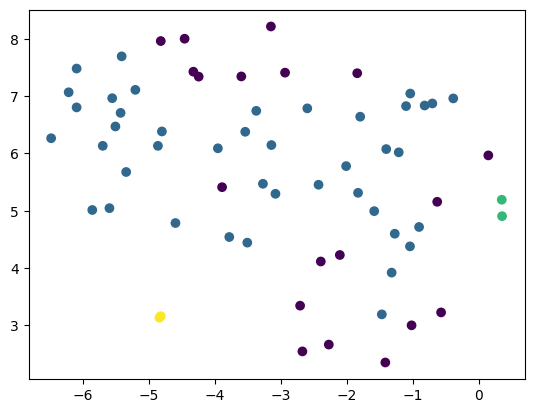

In [ ]:
plot_tsne(embedded_dict, dbscan)

## 4) Change corpus

###4.1) Calculate average Jaccard index
Done by calculating the Jaccard index of each documents to its k neighbors and averaging the results

In [ ]:
# Credit: https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial 

import spacy

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Defining the document
    doc = nlp(doc) 

    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    
    clean_doc = ' '.join(txt)
    return clean_doc

In [ ]:
import re

def clean_corpus(corpus):
    """ Cleans the corpus """
    brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in corpus)
    corpus_lemmas = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]
    return corpus_lemmas

In [ ]:
def jaccard_index(sentence1, sentence2):
    """ Calc Jaccard index for each pair of sentences """
    words1 = set(sentence1.split())
    words2 = set(sentence2.split())
    intersection = len(words1.intersection(words2))
    union = len(words1.union(words2))
    jaccard = intersection / union
    return jaccard

In [ ]:
def get_average_jaccard(corpus, k=1):
    """ Calculates the avergae Jaccard index by averaging each documents k nearest neighbors """

    cc = clean_corpus(corpus)

    all_neighbors = []
    for idx1, doc1 in enumerate(cc):
        doc1_neighbors = []
        for idx2, doc2 in enumerate(cc):
            # Avod repeated comparisons
            if idx2 > idx1:
                doc1_neighbors.append(jaccard_index(doc1, doc2))
        doc1_neighbors.sort(reverse=True)
        all_neighbors += doc1_neighbors[:k]
    avg = np.average(all_neighbors)
    return avg

#### Testing

In [ ]:
get_average_jaccard(['I love choclate', 'she loves choclate', 'I love Hummus'])

0.6666666666666666

### 4.2) Plotting Jaccard distance histogram

In [ ]:
def plot_jaccard_hist(df_short_sentences):
    '''creat a hist of jaccard scores'''

    indices_list = list(df_short_sentences.index)
    indices_list_short_1 = indices_list[1:4000] 

    # Create a list of sentence texts
    sentences = list(df_short_sentences.txt.loc[indices_list_short_1])

    # Compute the Jaccard index for all pairs of sentences
    jaccard_index_dict = {(indices_list_short_1[i],indices_list_short_1[j]): jaccard_index(sentences[i], sentences[j]) for i in range(len(sentences)) for j in range(i+1, len(sentences))}

    # Sort the dictionary by its values in descending order
    sorted_dict = dict(sorted(jaccard_index_dict.items(), key=lambda item: item[1], reverse=True))

    # extract the values from the dictionary
    dic_values = list(sorted_dict.values())

    # plot a histogram of the values
    plt.hist(dic_values, bins=50, range = (0,0.3))

    # set labels and title
    plt.xlabel('Values')
    plt.ylabel('Counts')
    plt.title('Histogram of Jaccard Indecs')

    # display the plot
    plt.show()

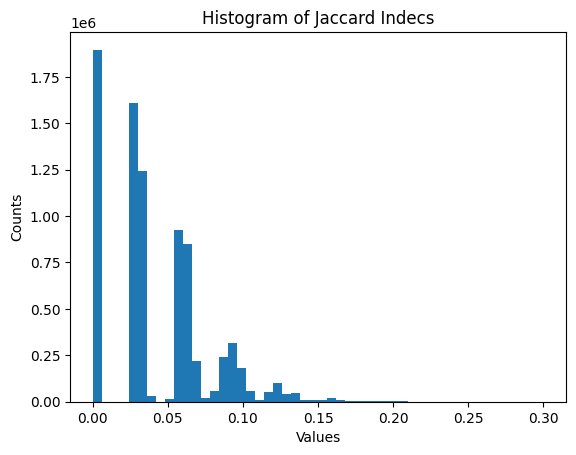

In [ ]:
plot_jaccard_hist(df_short_sentences)

### 4.3) Replace words

In [ ]:
def get_general_word_from_cluster(word_list, we_model):
    """ Finds the most similar words usind word embedding"""
    glove_words = list(we_model.index_to_key)
    known_words = [w for w in word_list if w in glove_words]
    if len(known_words) > 0:
        we_word = we_model.most_similar(known_words, topn=1)[0][0]
    else:
        we_word = None
    return we_word

In [ ]:
def add_general_word_to_word_dict(word_dict, word):
    """ Updating that the given words were replaced """
    word_dict[word] = {
                'protected': False,
                'lemma': False,
                'replaced': True}
    return word_dict

In [ ]:
def replace_words_in_df(df, cluster_dict, word_dict):
    """ Replaces the words in the dataframe """

    # Working with a copy of the df:
    df = df.copy()
    
    df['anon_txt'] = df['txt']

    # create a list of the "new" words and don't cluster them in the next round
    new_words = []
    jacc_indexes = []
    k = 1

    start_jacc_index = get_average_jaccard(df['anon_txt'], k=k)
    print('Starting average Jaccard index:', start_jacc_index)

    for key, words in cluster_dict.items(): 
        if key >= 0:  # Ignoring the -1 label
          if len(cluster_dict[key])<10: # so it will make sense!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                
                # Getting the general word
                general_word = get_general_word_from_cluster(words, glove_model)

                new_words.append(general_word)  # the list of new words
                print('\treplacing', words, 'in', general_word)
                for word in words:
                    if not word_dict[word]['protected']:
                        # Updaing the word dictionary that the words were replaced
                        word_dict[word]['replaced'] = True
                        word_dict = add_general_word_to_word_dict(word_dict, general_word)
                        # Replacing
                        df['anon_txt'] = df['anon_txt'].apply(lambda x: x.replace(word, general_word))
        # Checking current average Jaccard distance
        curr_jacc_index = get_average_jaccard(df['anon_txt'], k=k)
        jacc_indexes.append(curr_jacc_index)
    
    print('Final average Jaccard index:', get_average_jaccard(df['anon_txt'], k=k))
    df['anon_txt_history'] = df['anon_txt'].apply(lambda x: print_doc(x, word_dict))

    # Plotting
    plt.plot(jacc_indexes)
    plt.xlabel('Iteration')
    plt.ylabel('Average Jaccard index');

    return df, word_dict

Starting average Jaccard index: 0.3268395819866408
	replacing ['read', 'seller', 'future', 'product', 'books', 'designs', 'covers', 'great', 'quality', 'time', 'technical', 'listed', 'customer', 'information', 'service', 'good', 'ever', 'started', 'exactly', 'book', 'items', 'well', 'funny', 'use', 'excellent', 'would', 'order', 'business', 'purchase', 'cover', 'advertised', 'movie', 'got', 'coming', 'poor', 'review', 'beautiful', 'works', 'buy', 'right', 'wonderful', 'experience'] in any
	replacing ['seat', 'seats'] in front
	replacing ['julia', 'julie'] in anna
Final average Jaccard index: 0.5243055555555556


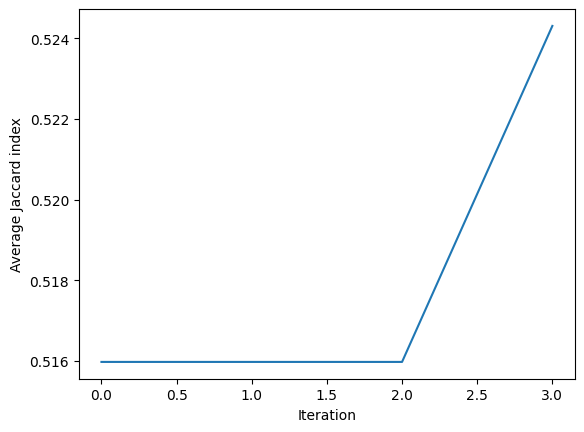

In [ ]:
#word_dict = create_word_dict(filtered_df_copy['txt'])
filtered_df_copy_2, word_dict = replace_words_in_df(filtered_df_copy, cluster_dict, word_dict)

In [ ]:
word_dict['is']

{'protected': True, 'lemma': None, 'replaced': None}

In [ ]:
filtered_df_copy_2

,txt,sentiment,num_of_words,anon_txt,anon_txt_history
1806,ninnia: this monitor is great. the service i g...,1,20,ninnia: this monitor is any. the any i any whe...,ninnia: (this) monitor (is) [any.] (the) [any]...
21174,beautiful books.: books arrived in good time a...,1,16,any any.: any arrived in any any and in any co...,[any] [any.:] [any] {arrive} (in) [any] [any] ...
23472,poor quality: the seat covers started coming l...,0,18,any any: the front any any any loose at the se...,[any] [any:] (the) [front] [any] [any] [any] l...
23473,poor quality.: the seat covers started coming ...,0,18,any any.: the front any any any loose at the s...,[any] [any.:] (the) [front] [any] [any] [any] ...
33050,"very funny: movie was great, arrived on time a...",1,20,"very any: any was any, arrived on any and in a...","(very) [any:] [any] (was) [any,] {arrive} (on)..."
33139,technical information: the product was exactly...,1,17,any any: the any was any as described and i an...,[any] [any:] (the) [any] (was) [any] (as) {des...
33789,julie & julia: not the greatest book i've ever...,0,19,anna & anna: not the anyest any i've any any. ...,[anna] & [anna:] (not) (the) anyest [any] {I} ...
43561,satisified customer: item shiped in a timely m...,1,19,satisified any: item shiped in a anyly manner ...,{satisifie} [any:] item {ship} (in) (a) anyly ...
49960,excellent: arrived as advertised on time in ex...,1,16,any: arrived as any on any in any condition. a...,[any:] {arrive} (as) [any] (on) [any] (in) [an...
57499,great review!!!: product arrived in a timely m...,1,18,any any!!!: any arrived in a anyly manner and ...,[any] [any!!!:] [any] {arrive} (in) (a) anyly ...


## 5) Running all

Getting dataframe

In [ ]:
%%time
# Getting the df
df = reading_bz_file(train_file)

CPU times: user 2min 50s, sys: 4.03 s, total: 2min 54s
Wall time: 3min


### 5.1) For 1K documents

In [ ]:
%%time
# Filtering
max_len = 20
df_short_sentences = df[df['num_of_words'] <= max_len] # Filtering using pandas is much faster
df_short_sentences = df_short_sentences[:1000]
print(df_short_sentences.shape)

(1000, 3)
CPU times: user 32.5 ms, sys: 0 ns, total: 32.5 ms
Wall time: 34.1 ms


Clustering

In [ ]:
%%time
embedded_dict = embed_corpus(df_short_sentences['txt'])
cluster_dict, dbscan = run_clustering(embedded_dict)

CPU times: user 837 ms, sys: 78.9 ms, total: 916 ms
Wall time: 791 ms


Plotting tSNE

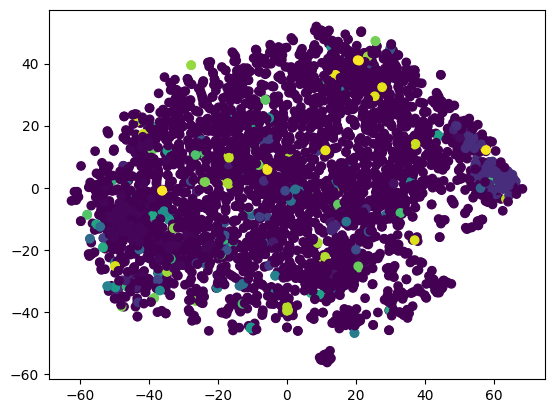

CPU times: user 56 s, sys: 283 ms, total: 56.3 s
Wall time: 34.2 s


In [ ]:
%%time
plot_tsne(embedded_dict, dbscan)

Plotting Jaccard index histogram

In [ ]:
%%time
#plot_jaccard_hist(df_short_sentences)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


Replacing words in df

In [ ]:
%%time
word_dict = create_word_dict(df_short_sentences['txt'])

CPU times: user 21.2 s, sys: 340 ms, total: 21.6 s
Wall time: 21.7 s


Starting average Jaccard index: 0.15203081818100286
	replacing ['heavy', 'led', 'edge', 'speed'] in power
	replacing ['seen', 'sure', 'six', 'took', 'unlike', 'another', 'year', 'many', 'goes', 'see', 'hardly', 'expect', 'yes', 'years', 'still', 'brought', 'far', 'anyone', 'anybody', 'third', 'however', 'much', 'thinking', 'doesnt', 'totally', 'mind', 'came', 'better', 'neither', 'well', 'reason', 'find', 'give', 'thought', 'two', 'let', 'therefore', 'hope', 'last', 'tell', 'right', 'wow', 'lie', 'things', 'disappointed', 'way', 'wrong', 'understand', 'heard', 'grew', 'always', 'look', 'shame', 'cant', 'yet', 'high', 'either', 'finally', 'five', 'takes', 'happens', 'didnt', 'already', 'get', 'prepared', 'nobody', 'worry', 'remember', 'hit', 'away', 'forget', 'sigh', 'unless', 'realise', 'nothing', 'unfortunately', 'actually', 'supposed', 'meant', 'behind', 'whole', 'close', 'impressed', 'take', 'otherwise', 'means', 'like', 'mean', 'something', 'second', 'bad', 'know', 'telling', 'next

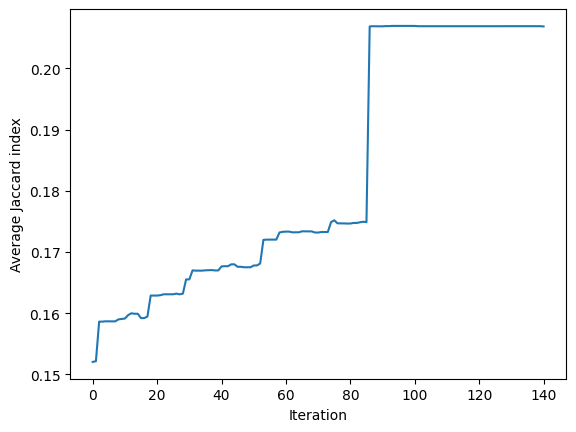

In [ ]:
%%time
filtered_df_copy_2, word_dict_2 = replace_words_in_df(df_short_sentences, cluster_dict, word_dict)

In [ ]:
filtered_df_copy_2

,txt,sentiment,num_of_words,anon_txt,anon_txt_history
100,textbook: book shipped quickly and was in exce...,1,16,textploduct: ploduct sdopeped quickly and was ...,textploduct: ploduct sdopeped quickly (and) (w...
204,haven't found better yet...: this is the only ...,1,20,haven't lound thele thele...: this is the only...,(haven't) lound thele thele...: (this) (is) (t...
332,"god's zoo: wonderful video, very comical and l...",1,20,"god's zoo: thelelul video, vely movieal and lo...","{god} zoo: thelelul video, vely movieal (and) ..."
446,good value: i love curve and this is a large b...,1,20,good value: i love culve and this is a lalge l...,[good] value: (i) love culve (and) (this) (is)...
669,janes all the worlds aircraft 1996-7: great to...,1,18,lluce all the wollds ailclalt 1996-7: gleat to...,lluce (all) (the) wollds ailclalt 1996-7: glea...
...,...,...,...,...,...
82906,arrow t50p 1997: never worked well. needed 10 ...,0,20,allow t50p 1997: nevel doinged thele. theleed ...,allow t50p 1997: nevel doinged thele. theleed ...
82992,shrimpboy: buy a cheap curved knife from the d...,0,20,shlimpgill: llee a cheaper culved knile llom t...,shlimpgill: llee (a) [cheaper] culved knile ll...
83443,cheap: don't buy. there are a whole lot better...,0,17,cheaper: don't llee. thele ale a thele thele t...,[cheaper:] (don't) llee. thele ale (a) thele t...
83569,"this tool is perfection!: finally, a hybrid be...",1,18,"this ploduct is pellection!: thele, a hyllid l...","(this) ploduct (is) pellection!: thele, (a) hy..."


###5.2) For 5K documets

In [ ]:
%%time
# Filtering
max_len = 20
df_short_sentences = df[df['num_of_words'] <= max_len] # Filtering using pandas is much faster
df_short_sentences = df_short_sentences[:5000]
print(df_short_sentences.shape)

(5000, 3)
CPU times: user 69.4 ms, sys: 1.99 ms, total: 71.4 ms
Wall time: 74.3 ms


Clustering

In [ ]:
%%time
embedded_dict = embed_corpus(df_short_sentences['txt'])
cluster_dict, dbscan = run_clustering(embedded_dict)

CPU times: user 3.79 s, sys: 246 ms, total: 4.04 s
Wall time: 3.25 s


Plotting tSNE

In [ ]:
%%time
#plot_tsne(embedded_dict, dbscan)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


Plotting Jaccard index histogram

In [ ]:
%%time
#plot_jaccard_hist(df_short_sentences)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10 µs


Replacing words in df

In [ ]:
%%time
word_dict = create_word_dict(df_short_sentences['txt'])

CPU times: user 1min 17s, sys: 1.15 s, total: 1min 18s
Wall time: 1min 19s


Starting average Jaccard index: 0.18832067649726197
	replacing ['aerosmith', 'metallica', 'nirvana', 'beatles', 'linkin', 'evanescence', 'coldplay', 'slipknot'] in zeppelin
	replacing ['six', 'two', 'three', 'four', 'five'] in few
	replacing ['florida', 'pittsburgh', 'chicago', 'texas', 'baltimore', 'seattle', 'ohio', 'dallas', 'kansas'] in denver
	replacing ['streisand', 'barbra'] in legolas
	replacing ['dogs', 'cats'] in animals
	replacing ['cheesecake', 'icecream'] in milkshake
	replacing ['insipid', 'overt', 'contrived'] in unjustifiable
	replacing ['f', 'b', 'r'] in l
	replacing ['snake', 'spider'] in turtle
	replacing ['poignant', 'riveting'] in heart-wrenching
	replacing ['stupid', 'dumb'] in silly
	replacing ['stepped', 'pulled'] in jumped
	replacing ['dumbest', 'stupidest'] in gayest
	replacing ['however', 'unfortunately', 'otherwise', 'perhaps', 'although', 'sadly'] in seems
	replacing ['right', 'though'] in but
	replacing ['yes', 'yeah'] in yep
	replacing ['clarinet', 'harmo

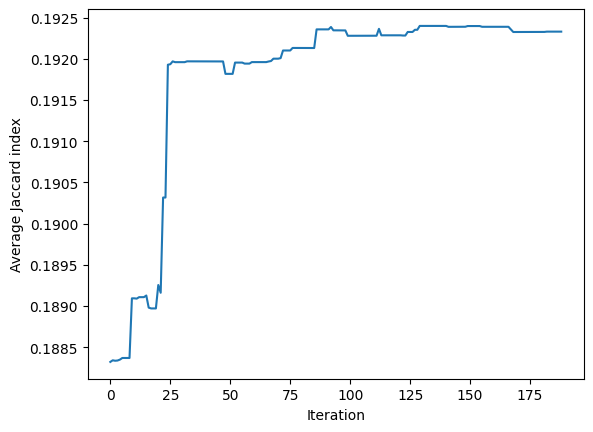

In [ ]:
%%time
filtered_df_copy_2, word_dict_2 = replace_words_in_df(df_short_sentences, cluster_dict, word_dict)

In [ ]:
filtered_df_copy_2

,txt,sentiment,num_of_words,anon_txt,anon_txt_history
100,textbook: book shipped quickly and was in exce...,1,16,textlook: look shipped quickly and was in exce...,textlook: look {ship} quickly (and) (was) (in)...
204,haven't found better yet...: this is the only ...,1,20,haven't lound 'lltel yet...: this is the only ...,(haven't) lound 'lltel yet...: (this) (is) (th...
332,"god's zoo: wonderful video, very comical and l...",1,20,"god's zoo: wondellul video, vely comical and l...","{god} zoo: wondellul video, vely comical (and)..."
446,good value: i love curve and this is a large b...,1,20,good value: i love culve and this is a lalge l...,good value: (i) love culve (and) (this) (is) (...
669,janes all the worlds aircraft 1996-7: great to...,1,18,janes all the wollds ailclalt 1996-7: gleat to...,{jane} (all) (the) wollds ailclalt 1996-7: gle...
...,...,...,...,...,...
426922,amazing: this is the best television show ever...,1,20,best: this is the lest television show evel. i...,[best:] (this) (is) (the) lest television show...
426948,amazing drama: lost - the complete third seaso...,1,19,best dlama: left - the comp'lle thild seasoni ...,[best] dlama: [left] - (the) comp'lle thild se...
427055,"great shoes!: i love these shoes, they are aff...",1,19,"gleat shoes!: i love these shoes, they ale all...","gleat [shoes!:] (i) love (these) [shoes,] (the..."
427197,good buy: these towel sets are very nice. embr...,1,20,good luy: these towel sets ale vely nice. emll...,good luy: (these) [towel] {set} ale vely nice....


### 5.3) For 43,870 documents

Filtering short docs

In [ ]:
%%time
# Filtering
max_len = 20
df_short_sentences = df[df['num_of_words'] <= max_len] # Filtering using pandas is much faster
print(df_short_sentences.shape)

(43870, 3)
CPU times: user 55.4 ms, sys: 996 µs, total: 56.4 ms
Wall time: 53.3 ms


Clustering

In [ ]:
%%time
embedded_dict = embed_corpus(df_short_sentences['txt'])
cluster_dict, dbscan = run_clustering(embedded_dict)

CPU times: user 26.8 s, sys: 1.38 s, total: 28.2 s
Wall time: 20.7 s


Plotting tSNE

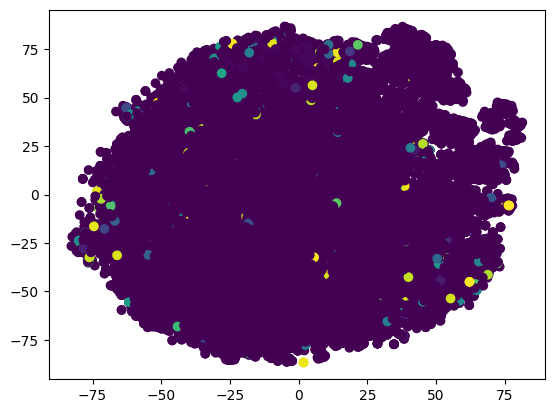

CPU times: user 11min 24s, sys: 1.01 s, total: 11min 25s
Wall time: 6min 56s


In [ ]:
%%time
plot_tsne(embedded_dict, dbscan)

Plotting Jaccard index histogram

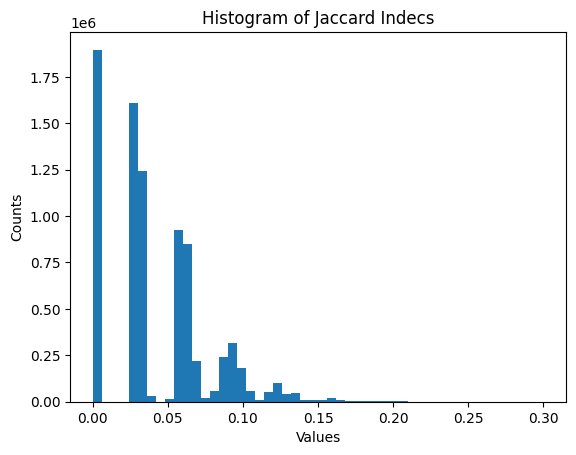

CPU times: user 1min 45s, sys: 4.91 s, total: 1min 50s
Wall time: 1min 51s


In [ ]:
%%time
plot_jaccard_hist(df_short_sentences)

Replacing words in df

In [ ]:
%%time
word_dict = create_word_dict(df_short_sentences['txt'])

CPU times: user 5min 54s, sys: 4.86 s, total: 5min 59s
Wall time: 6min 2s


In [ ]:
%%time
filtered_df_copy_2, word_dict_2 = replace_words_in_df(df_short_sentences, cluster_dict, word_dict)

In [ ]:
filtered_df_copy_2

,txt,sentiment,num_of_words,anon_txt,anon_txt_history
1806,ninnia: this monitor is great. the service i g...,1,20,ninnia: this monitor is any. the any i any whe...,ninnia: (this) monitor (is) [any.] (the) [any]...
21174,beautiful books.: books arrived in good time a...,1,16,any anys.: anys arrived in any any and in any ...,[any] anys.: anys {arrive} (in) [any] [any] (a...
23472,poor quality: the seat covers started coming l...,0,18,any any: the front anys any any loose at the s...,[any] [any:] (the) [front] anys [any] [any] lo...
23473,poor quality.: the seat covers started coming ...,0,18,any any.: the front anys any any loose at the ...,[any] [any.:] (the) [front] anys [any] [any] l...
33050,"very funny: movie was great, arrived on time a...",1,20,"very any: any was any, arrived on any and in a...","(very) [any:] [any] (was) [any,] {arrive} (on)..."
33139,technical information: the product was exactly...,1,17,any any: the any was any as described and i an...,[any] [any:] (the) [any] (was) [any] (as) {des...
33789,julie & julia: not the greatest book i've ever...,0,19,anna & anna: not the anyest any i've any any. ...,[anna] & [anna:] (not) (the) anyest [any] {I} ...
43561,satisified customer: item shiped in a timely m...,1,19,satisified any: item shiped in a anyly manner ...,{satisifie} [any:] item {ship} (in) (a) anyly ...
49960,excellent: arrived as advertised on time in ex...,1,16,any: arrived as any on any in any condition. a...,[any:] {arrive} (as) [any] (on) [any] (in) [an...
57499,great review!!!: product arrived in a timely m...,1,18,any any!!!: any arrived in a anyly manner and ...,[any] [any!!!:] [any] {arrive} (in) (a) anyly ...


In [ ]:
cluster_dict

{-1: ['reliable',
  'partial',
  'refunds',
  'soundtrack',
  'recipies',
  'mag',
  'make',
  'pound',
  'undamaged',
  'stars',
  'buildup',
  'lifelong',
  'matchmaking',
  'requiem',
  'communication',
  'torpedo',
  'blessed',
  'trying',
  'piss',
  'negroni',
  'reclaimed',
  'parcel',
  'evident',
  'insulting',
  'vampire',
  'strange',
  'longterm',
  'cup',
  'sigh',
  'dragon',
  'uneventful',
  'home',
  'blend',
  'troubles',
  'networking',
  'speedy',
  'bacco',
  'markings',
  'disciplines',
  'puit',
  'musicians',
  'anotherone',
  'software',
  'rock',
  'discovery',
  'moves',
  'hightech',
  'falls',
  'brand',
  'barna',
  'date',
  'munching',
  'woody',
  'nothin',
  'simpsons',
  'initiates',
  'automax',
  'battery',
  'goth',
  'craft',
  'goat',
  'minus',
  'smug',
  'doa',
  'triumphant',
  'hardcore',
  'staining',
  'bogus',
  'designer',
  'bacardi',
  'inaccuracies',
  'wipe',
  'manner',
  'purplish',
  'couples',
  'merchant',
  'lauderdale',
  'soa